# Document Clustering and Topic Modeling for Movie Synopses

In this project, we use unsupervised learning models to cluster synopses of [Top 100 Greatest Movies of All Time from IMDB](http://www.imdb.com/list/ls055592025/) into different groups, visualize the results and identify their latent topics/structures.

## Contents

<ul>
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
<li>[Part 3: TF-IDF](#Part-3:-TF-IDF)
<li>[Part 4: K-means clustering](#Part-4:-K-means-clustering)
<li>[Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)
</ul>

# Part 1: Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

We got 100 movie titles and their synoposes (combined from imdb and wikipedia).

In [2]:
# read the movie titles
titles = open('data/title_list.txt').read().split('\n')
titles = titles[:100] # ensures that only the first 100 are read in

# The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
# Each synoposis may consist of multiple paragraphs.
synopses_wiki = open('data/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('data/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

# Combine imdb and wiki to get full synoposes for the movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
# Because these movies synopses have already been ranked, we just need 
# to generate a list of ordered numbers for future usage.
ranks = range(1, 1+len(titles)) # 1~100

# Part 2: Tokenizing and Stemming

Let's load stopwords and a stemmer function from NLTK library. Some examples of stopwords are "a", "the", and "in", which don't convey significant meaning. Stemming is the process of breaking a word down into its plain form.

In [3]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print "We use " + str(len(stopwords)) + " stopwords from nltk library."
print "Examples:", stopwords[:10]

We use 153 stopwords from nltk library.
Examples: [u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your']


In [4]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text, stemming=True):
    tokens=[]
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if word not in stopwords:
                tokens.append(word.lower())
                
    # filter out any tokens which does not contain letters (e.g., numeric tokens, raw punctuation)            
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    if stemming:
        stems = [stemmer.stem(t) for t in filtered_tokens]
        return stems
    else:
        return filtered_tokens

In [5]:
# test
tokenization_and_stemming("Amy looked at her father's arm.")

[u'ami', u'look', u'father', "'s", u'arm']

Use our defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [6]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    tokenized_results = tokenization_and_stemming(i, stemming=False)
    docs_tokenized.extend(tokenized_results)

Let's create a mapping from stemmed words to original tokenized words for result interpretation.

In [7]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
# test
print vocab_frame_dict['soldier']

soldiers


# Part 3: TF-IDF

Now we will transform the 100 synopses to a matrix of TF-IDF features.

In [8]:
# define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, min_df=0.2, stop_words='english',
                              use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

# fit the vectorizer to synopses
tfidf_matrix = tfidf_model.fit_transform(synopses) 

print "In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms."

In total, there are 100 synoposes and 538 terms.


In [9]:
# save the terms identified by TF-IDF
tf_selected_words = tfidf_model.get_feature_names()

# Part 4: K-means clustering

Let's use K-means to group the movies.

In [10]:
from sklearn.cluster import KMeans

num_clusters = 3 # arbitrary choice
km = KMeans(n_clusters=num_clusters, random_state=0)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

## 4.1. Analyze K-means Result

In [11]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'cluster': clusters}
frame = pd.DataFrame(films, columns = ['rank', 'title', 'cluster'])
frame.head(10)

,rank,title,cluster
0,1,The Godfather,2
1,2,The Shawshank Redemption,2
2,3,Schindler's List,1
3,4,Raging Bull,2
4,5,Casablanca,2
5,6,One Flew Over the Cuckoo's Nest,1
6,7,Gone with the Wind,1
7,8,Citizen Kane,2
8,9,The Wizard of Oz,2
9,10,Titanic,2


In [12]:
print "Number of movies included in each cluster:"
frame['cluster'].value_counts().to_frame()

Number of movies included in each cluster:


,cluster
2,62
1,28
0,10


In [13]:
grouped = frame[['rank','cluster']].groupby('cluster')
print "Average rank (1 to 100) per cluster:"
grouped.mean()

Average rank (1 to 100) per cluster:


,rank
cluster,
0,55.300000
1,42.821429
2,53.193548


In [14]:
print "<Document clustering result by K-means>"

# km.cluster_centers_ denotes the importances of each items in centroid.
# need to sort it in descending order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print "Cluster " + str(i) + " words:" ,
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :10]: # get the top 6 words of each cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print vocab_frame_dict[tf_selected_words[ind]] + ", ",
    print 

    cluster_movies = frame.loc[frame.cluster == i, 'title'].values.tolist()
    print "Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): " 
    print ", ".join(cluster_movies), '\n'

<Document clustering result by K-means>
Cluster 0 words: george,  family,  singing,  performed,  captain,  marries,  filmed,  war,  ii,  dance, 
Cluster 0 titles (10 movies): 
The Sound of Music, Singin' in the Rain, It's a Wonderful Life, The Philadelphia Story, An American in Paris, The King's Speech, A Place in the Sun, Giant, Nashville, Yankee Doodle Dandy 

Cluster 1 words: army,  soldiers,  killing,  war,  commanded,  orders,  men,  general,  battle,  forcing, 
Cluster 1 titles (28 movies): 
Schindler's List, One Flew Over the Cuckoo's Nest, Gone with the Wind, Lawrence of Arabia, Star Wars, 2001: A Space Odyssey, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Saving Private Ryan, Raiders of the Lost Ark, Ben-Hur, Patton, Jaws, Braveheart, The Good, the Bad and the Ugly, Butch Cassidy and the Sundance Kid, Platoon, Dances with Wolve

We see that the main topics of the three clusters of movies are:
- Families, love and life
- Wars and battles
- Detective and crime

## 4.2. Plot K-means Result

In [15]:
# use PCA to select 2 principal components for visualization
pca = PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
X = pca.fit_transform(tfidf_matrix_np)
xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dictionary
cluster_colors = {0: 'k', 1: 'b', 2: 'r'}
#set up cluster names using a dictionary
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

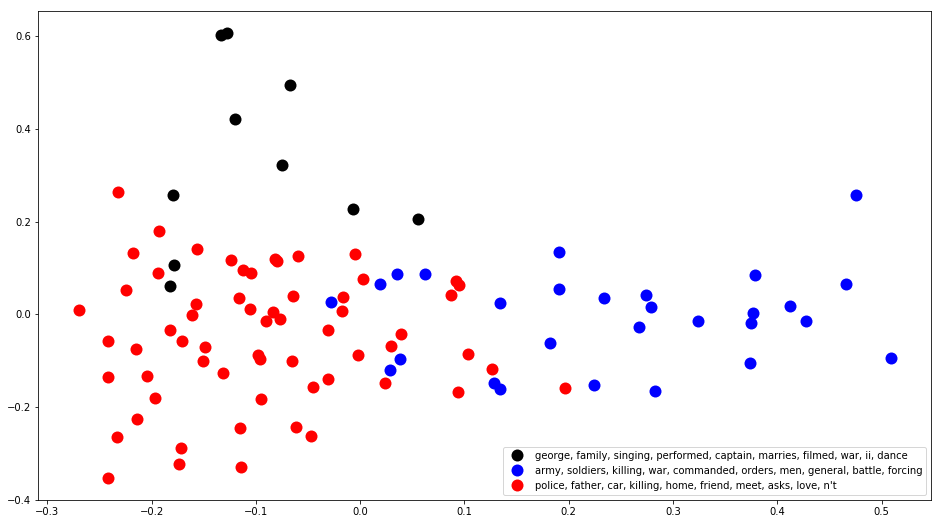

In [16]:
%matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
#groups = df.groupby(clusters)
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    
#show legend with only 1 point
ax.legend(numpoints=1,loc='lower right')
plt.show() 

# Part 5: Topic Modeling - Latent Dirichlet Allocation

Now we will use LDA to group the movies.

In [17]:
# Now we use synopses to build a 100*538 matrix
terms_dict = {tf_selected_words[x]:x for x in range(len(tf_selected_words))}

feature_matrix_synopses_tf = []
for i in synopses:
    current_doc_stats = [0] * len(tf_selected_words)
    allwords_stemmed = tokenization_and_stemming(i)
    for get_terms in allwords_stemmed:
        if get_terms in tf_selected_words:
            current_doc_stats[terms_dict[get_terms]] += 1
    current_doc_stats = np.asarray(current_doc_stats)
    feature_matrix_synopses_tf.append(current_doc_stats)
    
feature_matrix_synopses_tf = np.asarray(feature_matrix_synopses_tf)

In [18]:
model = lda.LDA(n_topics=3, n_iter=500, random_state=0)

- "model.topic\_word\_" saves the importance of tf_selected_words in LDA model, i.e. words similarity matrix. Its shape is (n_topics,num_of_selected_words)
- "model.doc\_topic\_" saves the document topic results, i.e. document topic matrix. Its shape is (num_of_documents, n_topics)

In [19]:
model.fit(feature_matrix_synopses_tf)
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 10

topic_keywords_list = []
for topic_dist in topic_word:    
    # Here we select the top 6 (n_top_words) words 
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-(n_top_words+1):-1] 
    for i in range(len(lda_topic_words)):
        lda_topic_words[i] = vocab_frame_dict[lda_topic_words[i]]
    topic_keywords_list.append(lda_topic_words.tolist())

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 538
INFO:lda:n_words: 61218
INFO:lda:n_topics: 3
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -447812
INFO:lda:<10> log likelihood: -413122
INFO:lda:<20> log likelihood: -402783
INFO:lda:<30> log likelihood: -398617
INFO:lda:<40> log likelihood: -396470
INFO:lda:<50> log likelihood: -395118
INFO:lda:<60> log likelihood: -393928
INFO:lda:<70> log likelihood: -393062
INFO:lda:<80> log likelihood: -392650
INFO:lda:<90> log likelihood: -391784
INFO:lda:<100> log likelihood: -390917
INFO:lda:<110> log likelihood: -390273
INFO:lda:<120> log likelihood: -390534
INFO:lda:<130> log likelihood: -390092
INFO:lda:<140> log likelihood: -390318
INFO:lda:<150> log likelihood: -389616
INFO:lda:<160> log likelihood: -389337
INFO:lda:<170> log likelihood: -388750
INFO:lda:<180> log likelihood: -388836
INFO:lda:<190> log likelihood: -388691
INFO:lda:<200> log likelihood: -387748
INFO:lda:<210> log likelihood: -387632
INFO:lda:<220> log likelihood: -3876

In [20]:
doc_topic = model.doc_topic_
topic_doc_dict = {}

print "<Document clustering result by LDA>"
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print "Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i])
    print "Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): " 
    print ', '.join(topic_doc_dict[i]), '\n'

<Document clustering result by LDA>
Cluster 0 words: days, n't, say, night, asks, car, away, killing, goes, police
Cluster 0 titles (48 movies): 
The Shawshank Redemption, Casablanca, One Flew Over the Cuckoo's Nest, The Wizard of Oz, Psycho, Sunset Blvd., Vertigo, On the Waterfront, West Side Story, E.T. the Extra-Terrestrial, 2001: A Space Odyssey, The Silence of the Lambs, Chinatown, Singin' in the Rain, Some Like It Hot, From Here to Eternity, Unforgiven, Raiders of the Lost Ark, Rocky, To Kill a Mockingbird, An American in Paris, My Fair Lady, Jaws, The Good, the Bad and the Ugly, Butch Cassidy and the Sundance Kid, The Apartment, The Exorcist, The Deer Hunter, The French Connection, City Lights, Tootsie, Fargo, The Grapes of Wrath, Shane, The Green Mile, Close Encounters of the Third Kind, Nashville, The Graduate, American Graffiti, Pulp Fiction, The African Queen, The Maltese Falcon, A Clockwork Orange, Taxi Driver, Double Indemnity, Rear Window, The Third Man, North by Northwes

We got a similar set of three clusters/topics as those we got with KMeans, but the way they are grouped is different.